In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
import random
import scipy
import math
import matplotlib

from keras.models import load_model
from scipy import stats

In [35]:
tf.get_logger().setLevel('ERROR')
model = load_model('Saved_models/model_4')

In [4]:
data = np.load('data/TOD.npy')

min_vector = np.empty([12,data.shape[0]])
max_vector = np.empty([12,data.shape[0]])
median_vector = []
def normalize(sample):
  for i in range(sample.shape[0]):
    for k in range(sample.shape[1]): 

      max_ = np.max(sample[i,k,:])
      max_vector[k,i] = max_
          
      min_ = np.min(sample[i,k,:])
      min_vector[k,i] = min_
    
      sample[i,k,:] = 2*((sample[i,k,:] - min_)/(max_-min_))-1
  return sample, min_vector, max_vector

def denormalize(M_vec, m_vec, sample):
  
  for i in range(sample.shape[0]):
    for k in range(sample.shape[1]):
      M = np.mean(M_vec[k])
      m = np.mean(m_vec[k])
      sample[i,k,:] = m + (M-m)*(sample[i,k,:]+1)/2
  
    return sample

In [5]:
z = np.random.normal(0.0, 1.0, (1, 500))
new = model.predict(z)
dataset = data[:,1,:,:].copy()
dataset, min_vector, max_vector = normalize(dataset)

new = denormalize(max_vector, min_vector, new)
test = np.load('data/TOD_test.npy')

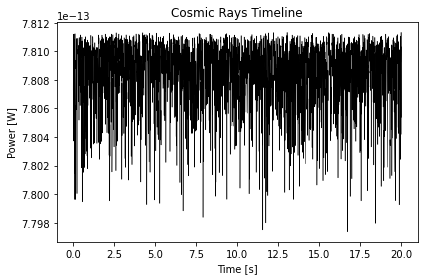

In [6]:
plt.figure(figsize=(6,4))
plt.plot(test[0,0,0], new[0,4], color = 'k', linewidth = 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.title('Cosmic Rays Timeline')
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'GAN'}>

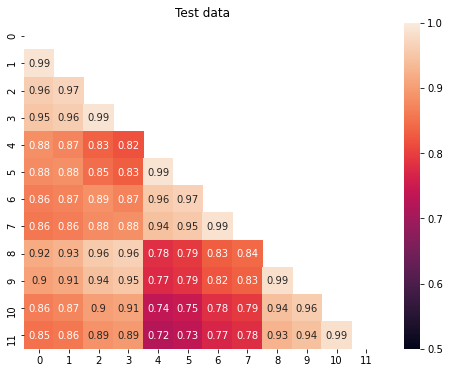

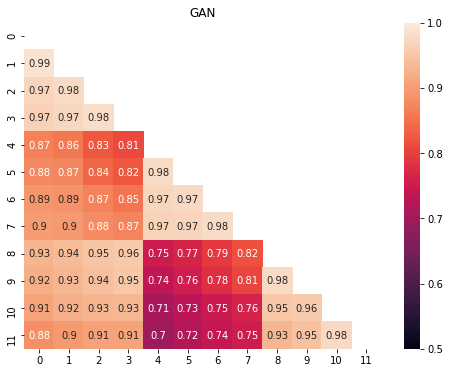

In [33]:
z = np.random.normal(0.0, 1.0, (100, 500))
new = model.predict(z)
new = denormalize(max_vector, min_vector, new)

matrix_true = np.corrcoef(test[0,1])
for i in range(1,test.shape[0]):
  matrix_true += np.corrcoef(test[i,1])
matrix_true = matrix_true/test.shape[0]

matrix = np.corrcoef(new[0])
for i in range(1,new.shape[0]):
  matrix += np.corrcoef(new[i])
matrix = matrix/new.shape[0]

mask = np.triu(np.ones_like(matrix, dtype=bool))

plt.figure(figsize = (8,6))
plt.title('Test data')
sns.heatmap(matrix_true, mask = mask, annot = True, vmin = 0.5, vmax = 1)

plt.figure(figsize = (8,6))
plt.title('GAN')
sns.heatmap(matrix, mask = mask, annot = True, vmin = 0.5, vmax = 1)

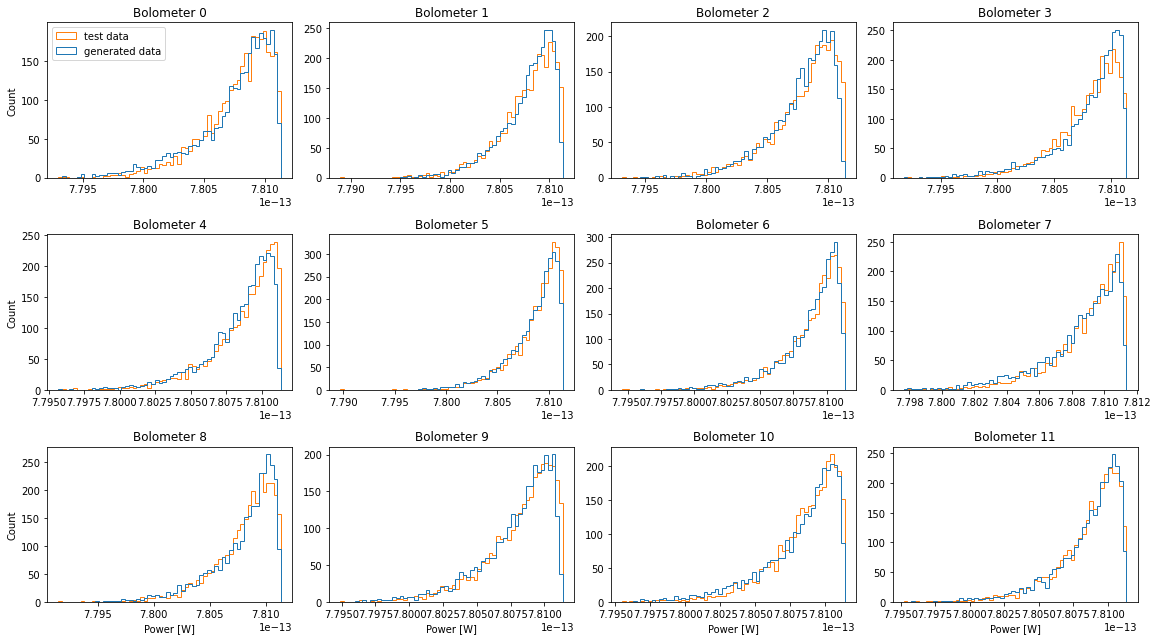

In [11]:
z = np.random.normal(0,1, (test.shape[0], 500))
g_data = model.predict(z)
g_data = denormalize(max_vector, min_vector, g_data)

fig, ax = plt.subplots(3,4,figsize = (16,9))

plt.setp(ax[-1, :], xlabel='Power [W]')
plt.setp(ax[:, 0], ylabel='Count')

for i in range(3):
  for k in range(4):
    ax[i,k].set_title('Bolometer ' + str(k + i*4))
    ax[i,k].hist([g_data[random.randint(0, g_data.shape[0]-1),k+i*4],test[random.randint(0,test.shape[0]-1),1,k+i*4]], 60,histtype = 'step', 
                 label=['generated data', 'test data'])
ax[0,0].legend(loc='upper left')
plt.tight_layout()

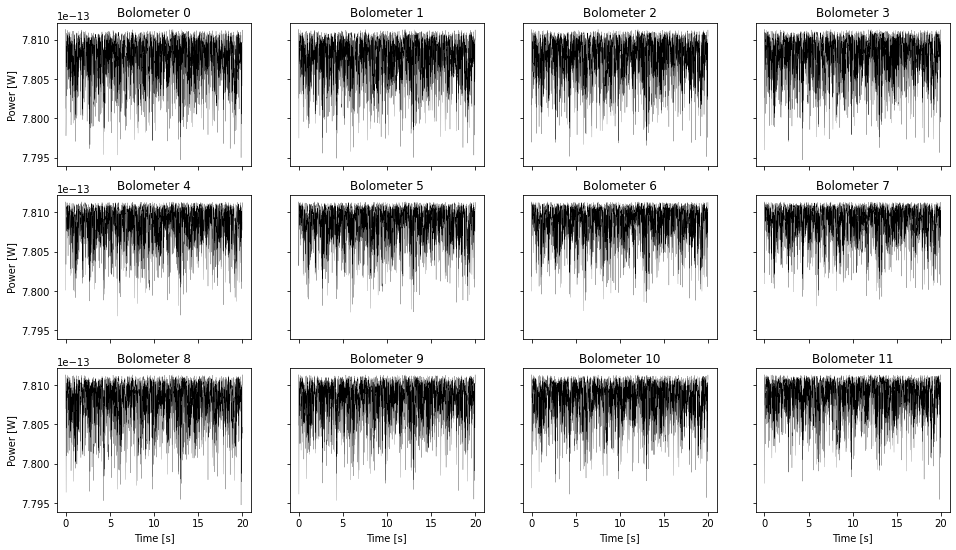

In [13]:
fig, ax = plt.subplots(3, 4,figsize = (16,9), sharex=True, sharey=True)

for i in range(3):
  for k in range(4):
    ax[i,k].set_title('Bolometer ' + str(k + i*4))
    ax[i,k].plot(data[0,0,0], new[0,k+i*4], linewidth = 0.17, color = 'k')
plt.setp(ax[-1, :], xlabel='Time [s]')
plt.setp(ax[:, 0], ylabel='Power [W]')
plt.show()

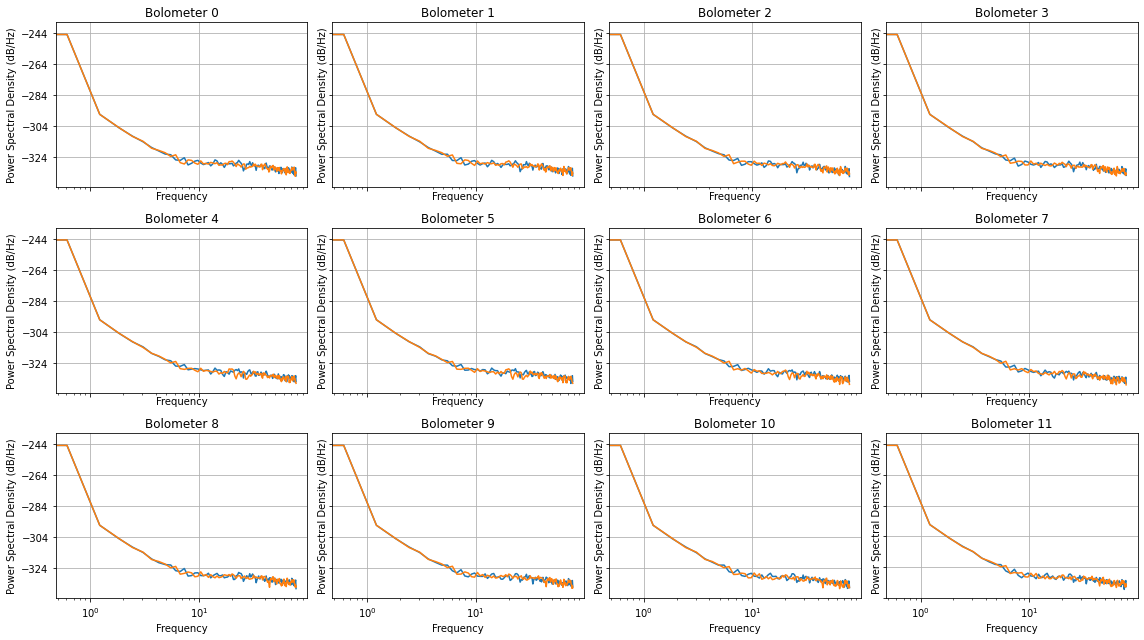

In [14]:
_ , ax = plt.subplots(3,4,figsize = (16,9), sharey=True, sharex=True)

for i in range(3):
  for k in range(4):
    ax[i,k].set_title('Bolometer ' + str(k + i*4))
    ax[i,k].psd(new[0,k+i*4], Fs = 156, label = 'generated')
    ax[i,k].psd(data[0,1,k+i*4], Fs = 156, label = 'real')
    ax[i,k].set_xscale('log')
plt.tight_layout()

In [15]:
n = test.shape[0]
correlation_t = np.empty((12,5356))


for bol in range(12):
  step = 0
  for i in range(n):
    for k in range(i+1, n):
      correlation_t[bol,step] = np.corrcoef(test[k,1,bol], test[i,1,bol])[0,1]
      step = step+1

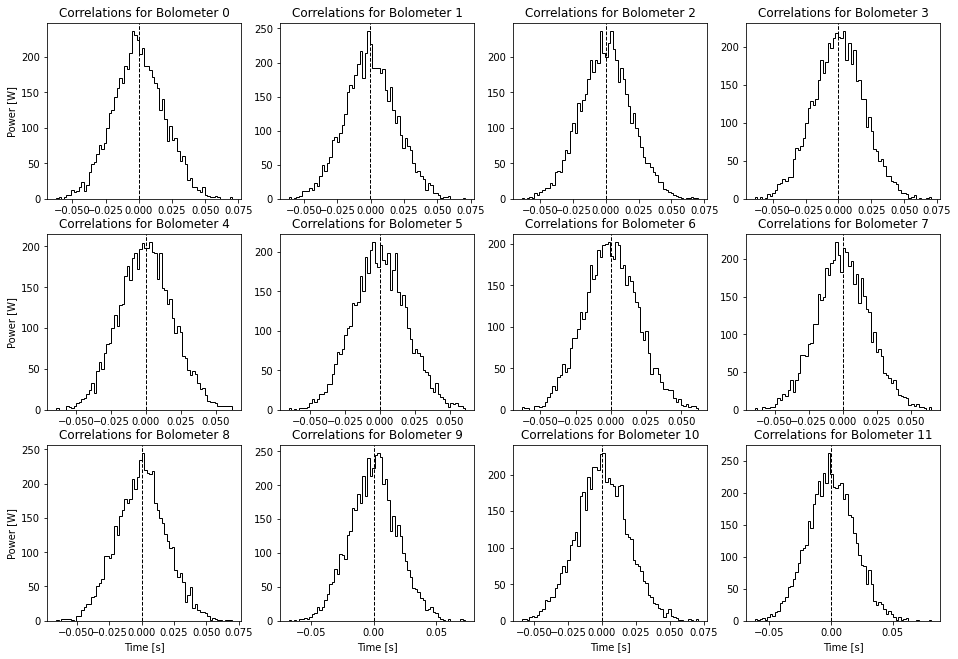

In [23]:
_, ax = plt.subplots(3,4,figsize = (16,11))

for i in range(3):
  for k in range(4):
    ax[i,k].set_title('Correlations for Bolometer ' + str(k + i*4))
    ax[i,k].hist(correlation_t[k+i*4], 70, histtype = 'step', color = 'k')
    ax[i,k].axvline(correlation_t[k+i*4].mean(), color='k', linestyle='dashed', linewidth=1, label = 'mean')
plt.setp(ax[-1, :], xlabel='Time [s]')
plt.setp(ax[:, 0], ylabel='Power [W]')
plt.show()

In [24]:
n = g_data.shape[0]
correlation = np.empty((12,5356))

for bol in range(12):
  step = 0
  for i in range(n):
    for k in range(i+1, n):
      correlation[bol,step] = np.corrcoef(g_data[k,bol], g_data[i,bol])[0,1]
      step = step+1

In [25]:
n = g_data.shape[0]
correlation_tg = np.empty((12,5356))

for bol in range(12):
  step = 0
  for i in range(n):
    for k in range(i+1, n):
      correlation_tg[bol,step] = np.corrcoef(g_data[k,bol], test[i,1,bol])[0,1]
      step = step+1

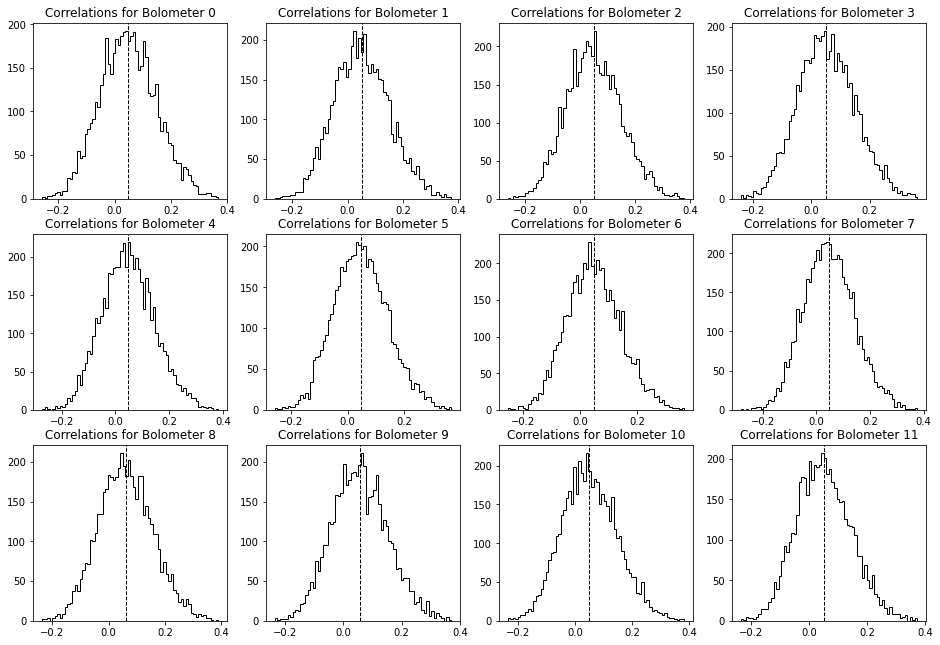

In [26]:
_, ax = plt.subplots(3,4,figsize = (16,11))

for i in range(3):
  for k in range(4):
    ax[i,k].set_title('Correlations for Bolometer ' + str(k + i*4))
    ax[i,k].hist(correlation[k+i*4], 70, color = 'k', histtype = 'step')
    ax[i,k].axvline(correlation[k+i*4].mean(), color='k', linestyle='dashed', linewidth=1, label = 'mean')

In [29]:
mean_test = correlation_t.mean(axis=1)
std_test = correlation_t.std(axis=1)
print("%f +/- %f" %(mean_test.mean(), std_test.mean()))

mean_gen = correlation.mean(axis=1)
std_gen = correlation.std(axis=1)
print("%f +/- %f" %(mean_gen.mean(), std_gen.mean()))

mean_tg = correlation_tg.mean(axis=1)
std_tg = correlation_tg.std(axis=1)
print("%f +/- %f" %(mean_tg.mean(), std_tg.mean()))

-0.000032 +/- 0.019199
0.050701 +/- 0.096984
0.000676 +/- 0.019363
